In [1]:
import matplotlib.pyplot as plt
import geopandas
import rasterio
from rasterio.plot import show
import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr
import pandas as pd
from shapely.affinity import scale, translate

import os
import geopandas as gpd
import numpy as np

# Apply the transformations
def transform_geometry(geom):
    # Add the constant to coordinates
    geom_translated = translate(geom, xoff=x_constant, yoff=y_constant)
    # Apply the scale factor
    geom_scaled = scale(geom_translated, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    return geom_scaled

import rioxarray


# Fig1. Location and study area

In [2]:
# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Importing
Parflow_file = os.path.dirname(parent_dir) + '/conus1_2006_preprocessed.zarr'
Parflow_test = xr.open_mfdataset(Parflow_file, engine='zarr', compat='override', coords='minimal')
df_SNOTEL_all = pd.read_csv(parent_dir + '/exp2/SNOTEL_all_info.csv', index_col=0)
df_SNOTEL = pd.read_csv(parent_dir + '/exp2/SNOTEL_sel_info.csv', index_col=0)

In [3]:
print('# of sites:',len(df_SNOTEL_all))


# of sites: 814


In [4]:
# Extracting the parflow elevation for SNOTEL sites 
list_elev = []
for i in range(len(df_SNOTEL.index)):
    list_elev.append(int(Parflow_test.isel(x = int(df_SNOTEL.conus1_i.iloc[i]), y=int(df_SNOTEL.conus1_j.iloc[i])).elev.values))
    


In [5]:
# filtering pixels with more than 50mm of maximun annual SWE

variable_data = Parflow_test.swe.max(dim='time').compute()

# Filter values greater than 50
filtered_data = Parflow_test.elev.where(variable_data > 50, drop=True)

# Flatten the data for histogram plotting
flattened_data = filtered_data.values.flatten()


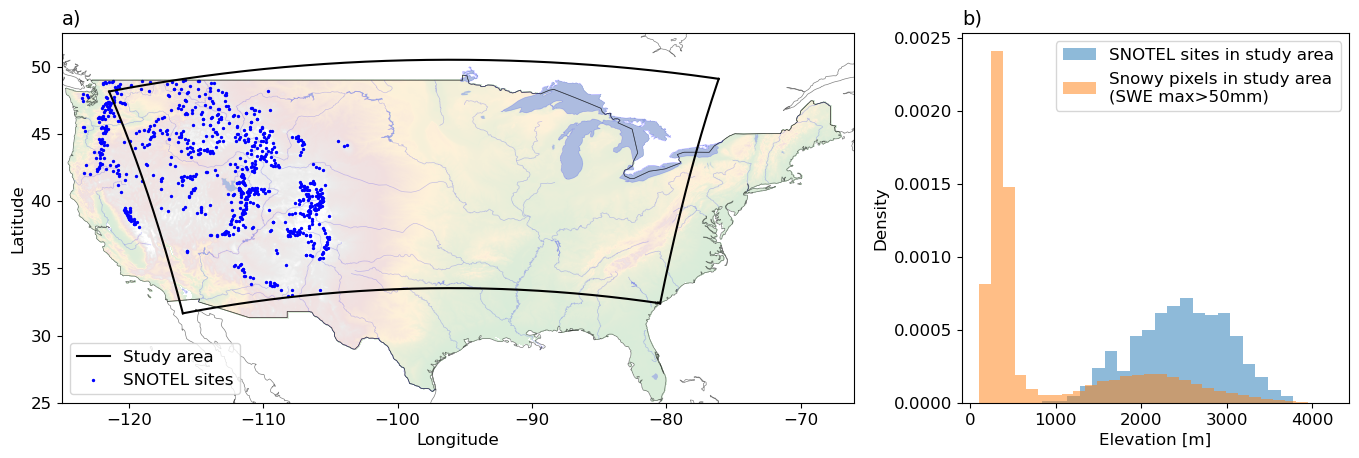

In [6]:
fontsize_fig=12

# Create a figure and define a 3x3 grid layout
fig = plt.figure(figsize=(17,4.8))
gs = GridSpec(1, 3, figure=fig)

# Subplot 
ax = fig.add_subplot(gs[0, 0:2])  

# Read shapefiles for continent, drainage network, and lakes
df_continent = geopandas.read_file(current_dir + '/shp/Americas.shp')
df_drainage_network = geopandas.read_file(current_dir + '/shp/Estados_Unidos_Hidrografia.shp')
df_lakes = geopandas.read_file(current_dir + '/shp/Estados_Unidos_Lagos.shp')

# Read elevation data
fp = current_dir + '/elevation.tif'
img = rasterio.open(fp, 'r')

# Define color values and corresponding colors for the elevation map
cvals = [-11, 0, 500, 1000, 2000, 3000]
colors = ["white", "green", "orange", "brown", "gray", "white"]
norm_blue = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm_blue, cvals), colors))
cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

# Create a plot
df_continent.boundary.plot(color='black', ax=ax, lw=0.5, alpha=0.5)
df_drainage_network.plot(color='blue', ax=ax, lw=0.5, alpha=0.2)
df_lakes.plot(color='blue', ax=ax, lw=0.5, alpha=0.2)
ax.set_xlabel('Longitude', fontsize=fontsize_fig)
ax.set_ylabel('Latitude', fontsize=fontsize_fig)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)
ax.set_xlim([-125, -66])
ax.set_ylim([25, 52.5])

# Show the elevation map with transparency
show((img, 1), ax=ax, cmap=cmap_blue, norm=norm_blue, alpha=0.15)

# CONUS area
ax.plot(Parflow_test.longitude.values[0,:], Parflow_test.latitude.values[0,:], color='black')
ax.plot(Parflow_test.longitude.values[:,-1],Parflow_test.latitude.values[:,-1], color='black')
ax.plot(Parflow_test.longitude.values[-1,:],Parflow_test.latitude.values[-1,:], color='black')
ax.plot(Parflow_test.longitude.values[:,0],Parflow_test.latitude.values[:,0], color='black', label='Study area')

# Snotel network
plt.scatter(df_SNOTEL_all.longitude, df_SNOTEL_all.latitude, label='SNOTEL sites', color='blue', s=2)
plt.legend(fontsize=fontsize_fig)

plt.title('a)', fontsize = fontsize_fig +2, loc='left')

ax2 = fig.add_subplot(gs[0, 2])
plt.hist(list_elev, bins=20, density=True, alpha =0.5 , label='SNOTEL sites in study area')
plt.hist(flattened_data, bins=30, density=True,  alpha =0.5,label='Snowy pixels in study area\n(SWE max>50mm)')
plt.legend(fontsize=fontsize_fig)
plt.xlabel('Elevation [m]', fontsize = fontsize_fig)
plt.ylabel('Density',  fontsize = fontsize_fig)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)
plt.title('b)',  fontsize = fontsize_fig + 2, loc='left')

# Saving
plt.savefig('Fig1.jpg', bbox_inches='tight', pad_inches=0.1)

# Fig 2 SNOTEL model

In [7]:
# Importing data
obs_file = parent_dir + '/exp2/LSTM_obs_ep_100/CONUS_test.nc'
obs_test = xr.open_mfdataset(obs_file, engine='netcdf4', compat='override', coords='minimal')
obs_test = obs_test.sel(time=slice('2005-10-01','2006-09-25')).isel(y=slice(0,1800),x=slice(0,3200))
obs_test = obs_test.transpose('y', 'x', 'time')
obs_test = obs_test.rename({'__xarray_dataarray_variable__':'swe'})

true_file = [os.path.dirname(parent_dir) + '/conus1_2005_preprocessed.zarr',os.path.dirname(parent_dir) + '/conus1_2006_preprocessed.zarr']
true_test = xr.open_mfdataset(true_file, engine='zarr', compat='override', coords='minimal')
true_test = true_test.sel(time=slice('2005-10-01','2006-09-25')).isel(y=slice(0,1800),x=slice(0,3200))


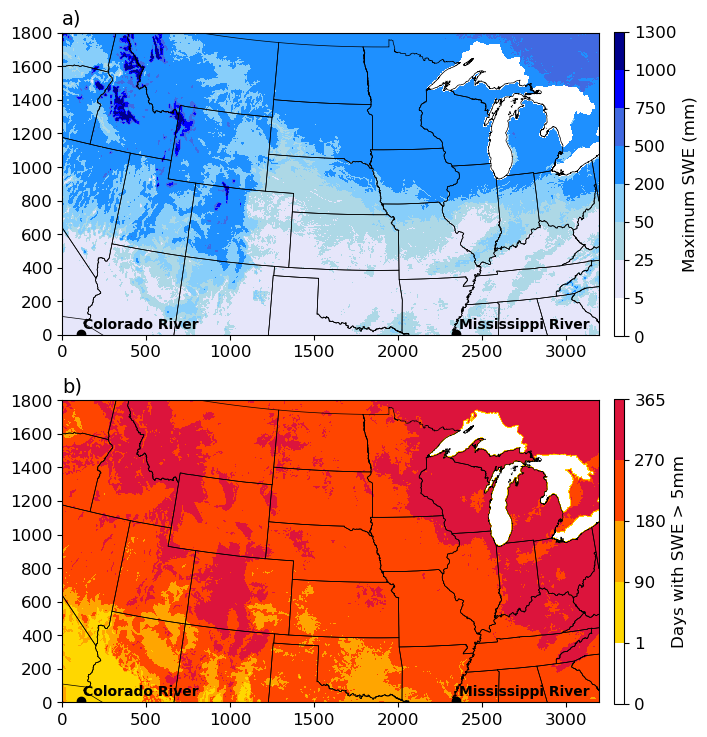

In [8]:

fontsize_fig=12

# Define the colors and corresponding ranges
colors = ['white', 'lavender', 'lightblue', 'lightskyblue', 'dodgerblue', 'royalblue', 'blue', 'darkblue']
ranges = [0, 5, 25, 50, 200, 500, 750, 1000, 1300]  # Define 8 intervals

# Create the colormap using ListedColormap
cmap = ListedColormap(colors)

# Create BoundaryNorm to map values to the colormap based on the defined ranges
norm = BoundaryNorm(boundaries=ranges, ncolors=len(colors))

fig = plt.figure(figsize=(7, 7.5))
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.04])  # Add space for the colorbar

vmax = 1300
bins = 500

# First subplot
ax1 = fig.add_subplot(gs[0, 0:2]) 
img1 = ax1.imshow(obs_test.swe.max(dim='time'), origin='lower', cmap=cmap, norm=norm)
ax1.set_title('a)', loc='left', fontsize=14)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

# Mouth Colorado river (Mexico)
ax1.scatter([110],[5], color='black')
ax1.text(110 + 15, 40, "Colorado River", fontsize=fontsize_fig-2,  weight='bold', color='black')

# Mississippi river (Greenville)
ax1.scatter([2350],[5], color='black')
ax1.text(2350 + 15, 40, "Mississippi River", fontsize=fontsize_fig-2,  weight='bold', color='black')

# Add a single colorbar for all subplots
cbar_ax = fig.add_subplot(gs[0, 2])  # Extra axis for colorbar
cbar = fig.colorbar(img1, cax=cbar_ax, boundaries=ranges)
cbar.ax.set_ylabel('Maximum SWE (mm)',fontsize = fontsize_fig)  # Add label to colorbar
plt.yticks(fontsize=fontsize_fig)


# Define the colors and corresponding ranges
colors = ['white', 'gold', 'orange', 'orangered', 'red', 'crimson']
ranges = [0, 1, 90, 180, 270, 365]  # Define 5 intervals

# Create the colormap using ListedColormap
cmap = ListedColormap(colors)

# Create BoundaryNorm to map values to the colormap based on the defined ranges
norm = BoundaryNorm(boundaries=ranges, ncolors=len(colors))


threshold_min = 5
ax2 = fig.add_subplot(gs[1, 0:2]) 
img2 = ax2.imshow(((obs_test.swe > threshold_min).sum(dim='time')), origin='lower', cmap=cmap, norm=norm)
ax2.set_title('b)', loc='left', fontsize=fontsize_fig +2 )
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

cbar_ax = fig.add_subplot(gs[1, 2])  # Extra axis for colorbar
cbar = fig.colorbar(img2, cax=cbar_ax,  boundaries=ranges)
cbar.ax.set_ylabel('Days with SWE > 5mm', fontsize = fontsize_fig)  # Add label to colorbar
plt.yticks(fontsize=fontsize_fig)

# Mouth Colorado river (Mexico)
ax2.scatter([110],[5], color='black')
ax2.text(110 + 15, 40, "Colorado River", fontsize=fontsize_fig-2, weight='bold', color='black')

# Mississippi river (Greenville)
ax2.scatter([2350],[5], color='black')
ax2.text(2350 + 15, 40, "Mississippi River", fontsize=fontsize_fig-2, weight='bold', color='black')


        
shapefile_path = parent_dir + '/Analysis/shp/USA-state.shp'
gdf = gpd.read_file(shapefile_path)

# Define the custom CRS
custom_crs = "+proj=lcc +lat_1=33 +lat_2=45 +lon_0=-96 +lat_0=39 +a=6378137 +b=6356752.31"

# Set CRS in a GeoDataFrame (replace 'gdf' with your GeoDataFrame variable)
gdf = gdf.to_crs(custom_crs)

# Define your constants
x_constant = 1885055.4995  # The constant to add to the x-coordinate
y_constant = 604957.0654  # The constant to add to the y-coordinate
scale_factor = 0.001  # The scale factor

# Apply the transformation to all geometries
gdf['geometry'] = gdf['geometry'].apply(transform_geometry)


gdf.geometry.boundary.plot(ax=ax1, color='black', lw=0.5)
gdf.geometry.boundary.plot(ax=ax2, color='black', lw=0.5)
    
ax1.set_xlim(0,3200)
ax1.set_ylim(0,1800)
ax2.set_xlim(0,3200)
ax2.set_ylim(0,1800)

# saving
plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig('Fig2.jpg', bbox_inches='tight', pad_inches=0.1)

In [9]:
df = pd.read_csv('/home/ld7565/hydrogen_arch/SWE/Analysis/Exp1_results.csv',index_col=0)

# Fig 3. Comparison EXP1

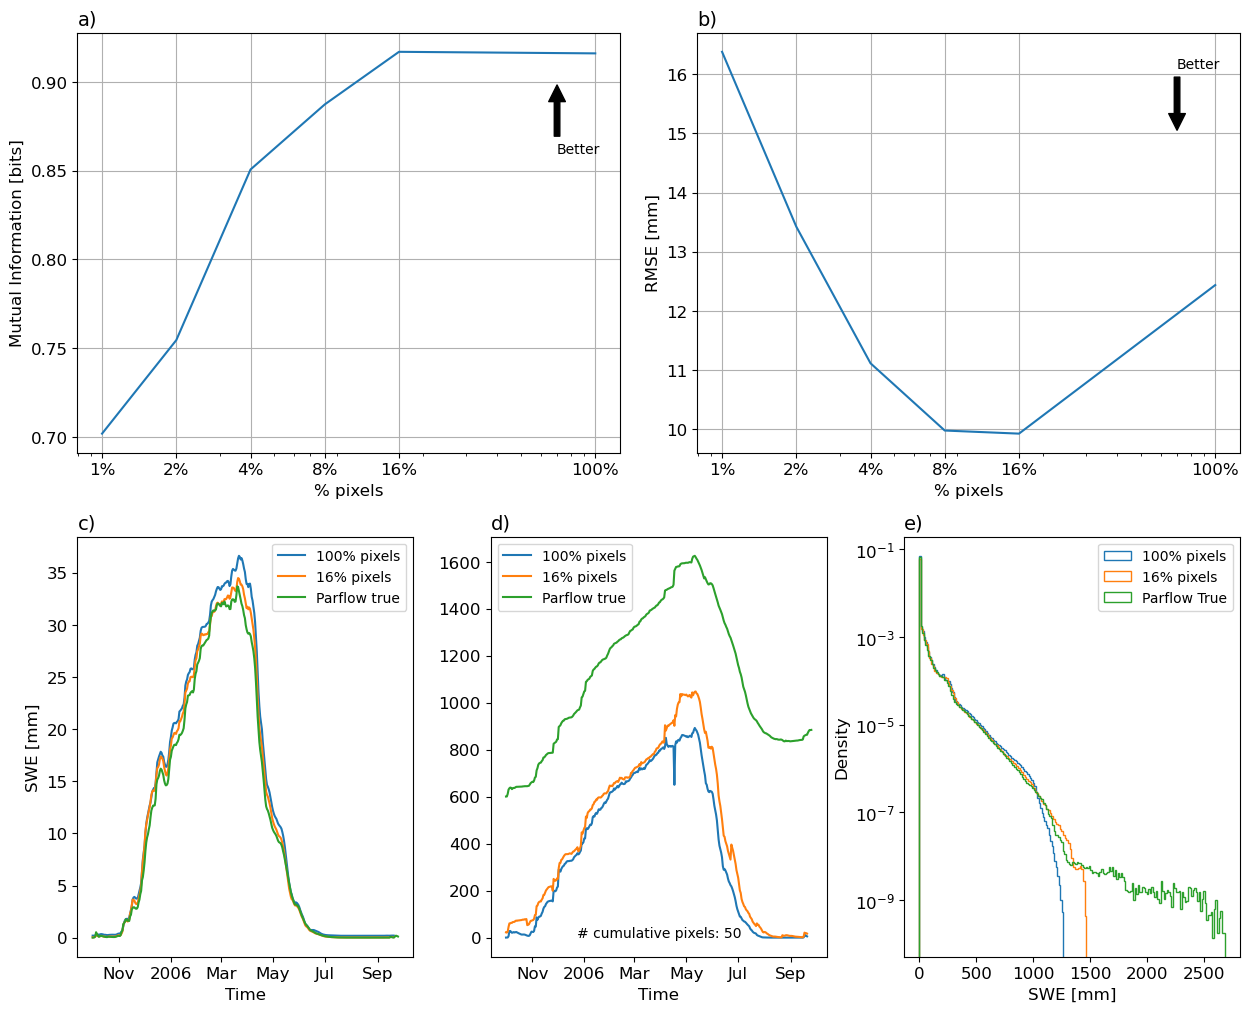

In [10]:
fontsize_fig=12

# Define custom tick positions and labels
tick_positions = [1, 2, 4, 8, 16, 100]
tick_labels = ['1%', '2%', '4%', '8%', '16%', '100%']

fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 6, figure=fig)  

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.6, hspace=0.2)  # Increase these values as needed


# First subplot
ax1 = fig.add_subplot(gs[0, 0:3]) 
plt.title('a)', loc='left', fontsize=14)
plt.plot(df.drop(32).index,df.drop(32).MI_temp_val,label='Temporal validation')
plt.xscale('log')
plt.grid()
plt.xlabel('% pixels', fontsize=fontsize_fig)
plt.ylabel('Mutual Information [bits]',fontsize=fontsize_fig)
plt.xticks(tick_positions, tick_labels)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

# Draw an arrow
plt.annotate(
    'Better',  # Text label
    xy=(70, 0.90),  # Arrow tip (destination point)
    xytext=(70, 0.86),  # Starting point of the arrow
    arrowprops=dict(facecolor='black', shrink=0.05)  # Arrow properties
)


ax2 = fig.add_subplot(gs[0, 3:6])
plt.title('b)', loc='left', fontsize=fontsize_fig+2)
plt.plot(df.drop(32).index,df.drop(32).RMSE_temp_val,label='Temporal validation')
plt.xscale('log')
plt.grid()
plt.xlabel('% pixels',fontsize=fontsize_fig)
plt.ylabel('RMSE [mm]',fontsize=fontsize_fig)
plt.xticks(tick_positions, tick_labels,fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

# Draw an arrow
plt.annotate(
    'Better',  # Text label
    xy=(70, 15),  # Arrow tip (destination point)
    xytext=(70, 16.1),  # Starting point of the arrow
    arrowprops=dict(facecolor='black', shrink=0.05)  # Arrow properties
)


p100_file = parent_dir + '/exp1/LSTM_perc_100_ep_25/CONUS_test.nc'
p100_test = xr.open_mfdataset(p100_file, engine='netcdf4', compat='override', coords='minimal')
p100_test = p100_test.sel(time=slice('2005-10-01','2006-09-25'))
p100_test = p100_test.transpose('y', 'x', 'time')

p16_file = parent_dir + '/exp1/LSTM_perc_16_c_ep_25/CONUS_test.nc'
p16_test = xr.open_mfdataset(p16_file, engine='netcdf4', compat='override', coords='minimal')
p16_test = p16_test.sel(time=slice('2005-10-01','2006-09-25'))
p16_test = p16_test.transpose('y', 'x', 'time')

true_file = [os.path.dirname(parent_dir) + '/conus1_2005_preprocessed.zarr',os.path.dirname(parent_dir) +'/conus1_2006_preprocessed.zarr']
true_test = xr.open_mfdataset(true_file, engine='zarr', compat='override', coords='minimal')
true_test = true_test.sel(time=slice('2005-10-01','2006-09-25')).isel(y=slice(0,1800),x=slice(0,3300))


ax3 = fig.add_subplot(gs[1, 0:2])
p100_test.__xarray_dataarray_variable__.mean(dim=['x','y']).plot(label='100% pixels')
p16_test.__xarray_dataarray_variable__.mean(dim=['x','y']).plot(label='16% pixels')
true_test.swe.mean(dim=['x','y']).plot(label='Parflow true')
plt.ylabel('SWE [mm]',fontsize=fontsize_fig)
plt.xlabel('')
plt.title('c)', loc='left', fontsize=fontsize_fig+2)
plt.xlabel('Time', fontsize=fontsize_fig)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)
plt.legend(fontsize=fontsize_fig-2)


ax4 = fig.add_subplot(gs[1, 2:4])
threshold = 1300  # Set your desired threshold

filtered_data = p100_test.__xarray_dataarray_variable__.where(true_test.swe.max(dim='time') > threshold)
filtered_data.mean(dim=['x', 'y']).plot(label='100% pixels')
filtered_data = p16_test.__xarray_dataarray_variable__.where(true_test.swe.max(dim='time') > threshold)
filtered_data.mean(dim=['x', 'y']).plot(label='16% pixels')
filtered_data = true_test.swe.where(true_test.swe.max(dim='time') > threshold)
filtered_data.mean(dim=['x', 'y']).plot(label='Parflow true')
plt.legend(fontsize=fontsize_fig-2)
plt.ylabel('')
plt.xlabel('Time', fontsize=fontsize_fig)
plt.title('d)', loc='left', fontsize=fontsize_fig+2)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

cum_pixels = np.nansum(~filtered_data.max(dim='time').isnull().values)
plt.text(13140,0, f'# cumulative pixels: {cum_pixels}')

ax5 = fig.add_subplot(gs[1, 4:6])
p100_test.__xarray_dataarray_variable__.plot(bins = 100,histtype = 'step', density=True, label='100% pixels')
p16_test.__xarray_dataarray_variable__.plot(bins =100, histtype = 'step', density=True, label='16% pixels')
true_test.swe.plot(bins = 200,histtype = 'step', density=True, label='Parflow True')
plt.yscale('log')
plt.legend(fontsize=fontsize_fig-2)
plt.title('e)', loc='left', fontsize=14)
plt.ylabel('Density',fontsize=fontsize_fig)
plt.xlabel('SWE [mm]',fontsize=fontsize_fig)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

plt.savefig('Fig3.jpg', bbox_inches='tight', pad_inches=0.1)



# EXP2

In [11]:

# NLDAS with bias correction
file_yhat_a_obs = parent_dir + '/exp2/LSTM_obs_ep_100/full_testing.nc'
yhat_a_obs = xr.open_mfdataset(file_yhat_a_obs, engine='netcdf4', compat='override', coords='minimal')

file_yhat_a_fine = parent_dir + '/exp2/LSTM_obs_fine_ep_100/full_testing.nc' #UPDATED
yhat_a_fine = xr.open_mfdataset(file_yhat_a_fine, engine='netcdf4', compat='override', coords='minimal')

file_exp1 = parent_dir + '/exp2/LSTM_obs_ep_0/full_testing.nc'  #UPDATED
yhat_exp1 = xr.open_mfdataset(file_exp1, engine='netcdf4', compat='override', coords='minimal')

# NLDAS without bias correction
file_yhat_b_obs_2y = parent_dir +  '/exp2/LSTM_obs_long_ep_102/LSTM_best_epock.nc'
yhat_b_obs_2y = xr.open_mfdataset(file_yhat_b_obs_2y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_fine_2y = parent_dir + '/exp2/LSTM_obs_long_fine_ep_102/LSTM_best_epock.nc'
yhat_b_fine_2y = xr.open_mfdataset(file_yhat_b_fine_2y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_obs_4y = parent_dir + '/exp2/LSTM_obs_long_ep_104/LSTM_best_epock.nc'
yhat_b_obs_4y = xr.open_mfdataset(file_yhat_b_obs_4y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_fine_4y = parent_dir + '/exp2/LSTM_obs_long_fine_ep_104/LSTM_best_epock.nc'
yhat_b_fine_4y = xr.open_mfdataset(file_yhat_b_fine_4y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_obs_6y = parent_dir + '/exp2/LSTM_obs_long_ep_106/LSTM_best_epock.nc'
yhat_b_obs_6y = xr.open_mfdataset(file_yhat_b_obs_6y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_fine_6y = parent_dir + '/exp2/LSTM_obs_long_fine_ep_106/LSTM_best_epock.nc'
yhat_b_fine_6y = xr.open_mfdataset(file_yhat_b_fine_6y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_obs_8y = parent_dir + '/exp2/LSTM_obs_long_ep_108/LSTM_best_epock.nc'
yhat_b_obs_8y = xr.open_mfdataset(file_yhat_b_obs_8y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_fine_8y = parent_dir + '/exp2/LSTM_obs_long_fine_ep_108/LSTM_best_epock.nc'
yhat_b_fine_8y = xr.open_mfdataset(file_yhat_b_fine_8y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_obs_10y = parent_dir + '/exp2/LSTM_obs_long_ep_100/LSTM_best_epock.nc'
yhat_b_obs_10y = xr.open_mfdataset(file_yhat_b_obs_10y, engine='netcdf4', compat='override', coords='minimal')

file_yhat_b_fine_10y = parent_dir + '/exp2/LSTM_obs_long_fine_ep_100/LSTM_best_epock.nc'
yhat_b_fine_10y = xr.open_mfdataset(file_yhat_b_fine_10y, engine='netcdf4', compat='override', coords='minimal')
                                   
file_y = parent_dir + '/exp2/SWE_obs_test.zarr'
y = xr.open_mfdataset(file_y, engine='zarr', compat='override', coords='minimal')
y = y.sel(time=slice('2005-10-01','2006-09-25'),y=slice(0,8074))

In [12]:
df_exp2 = pd.read_csv(parent_dir + '/Analysis/Exp2_results.csv',index_col=0)

# Fig 4 MI and RMSE between EXP1 and EXP2

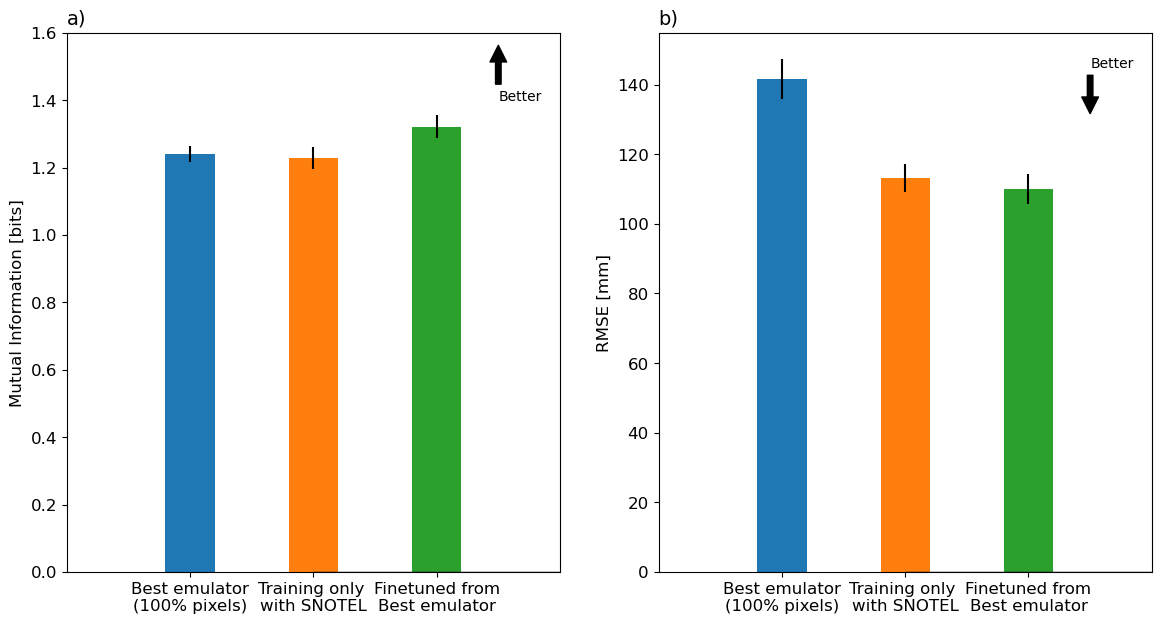

In [13]:
fontsize_fig=12

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
bar_width = 0.4
plt.bar([1],df_exp2.MI_exp1['0_bias'], yerr = df_exp2.MI_exp1_std['0_bias'],width = bar_width, label='Best emulator (100% pixels)')
plt.bar([2], df_exp2.MI_obs['0_bias'], yerr = df_exp2.MI_obs_std['0_bias'],width = bar_width, label='Training only with observations')
plt.bar([3],df_exp2.MI_fine['0_bias'], yerr = df_exp2.MI_fine_std['0_bias'],width = bar_width, label='Finetuning to observations')


plt.plot([2,4], [0,0], color='black', lw=1, label='Standard deviation')
#plt.legend()
plt.ylim(0, 1.6)
plt.xlim(0,4)
plt.ylabel('Mutual Information [bits]',fontsize=fontsize_fig)
#plt.xlabel('Models')
plt.xticks(ticks=[1,2,3], labels=['Best emulator\n(100% pixels)','Training only \nwith SNOTEL','Finetuned from\nBest emulator'],fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)
plt.title('a)', loc='left', fontsize=fontsize_fig+2)

# Draw an arrow
plt.annotate(
    'Better',  # Text label
    xy=(3.5, 1.57),  # Arrow tip (destination point)
    xytext=(3.5, 1.4),  # Starting point of the arrow
    arrowprops=dict(facecolor='black', shrink=0.05)  # Arrow properties
)




plt.subplot(1,2,2)
plt.bar([1],df_exp2.RMSE_exp1['0_bias'], yerr = df_exp2.RMSE_exp1_std['0_bias'],width = bar_width, label='Best emulator (100% pixels)')
plt.bar([2],df_exp2.RMSE_obs['0_bias'], yerr = df_exp2.RMSE_obs_std['0_bias'],width = bar_width, label='Training only \nwith observations')
plt.bar([3],df_exp2.RMSE_fine['0_bias'], yerr = df_exp2.RMSE_fine_std['0_bias'],width = bar_width, label='Finetuning to \nobservations')

plt.plot([2,4], [0,0], color='black', lw=1, label='Standard deviation')
#plt.legend()
plt.xlim(0,4)
#plt.ylim(100, 170)
plt.ylabel('RMSE [mm]',fontsize=fontsize_fig)
plt.xticks(ticks=[1,2,3], labels=['Best emulator\n(100% pixels)','Training only \nwith SNOTEL','Finetuned from\nBest emulator'],fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)
plt.title('b)', loc='left', fontsize=fontsize_fig+2)

# Draw an arrow
plt.annotate(
    'Better',  # Text label
    xy=(3.5, 131),  # Arrow tip (destination point)
    xytext=(3.5, 145),  # Starting point of the arrow
    arrowprops=dict(facecolor='black', shrink=0.05)  # Arrow properties
)

plt.savefig('Fig4.jpg', bbox_inches='tight', pad_inches=0.1)

# Fig 5 Comparison fo SWE prediction at CONUS scale

In [14]:
fine_file = parent_dir + '/exp2/LSTM_obs_fine_ep_100/CONUS_test.nc'
fine_test = xr.open_mfdataset(fine_file, engine='netcdf4', compat='override', coords='minimal')
fine_test = fine_test.sel(time=slice('2005-10-01','2006-09-25')).isel(y=slice(0,1800),x=slice(0,3200))
fine_test = fine_test.transpose('y', 'x', 'time')
fine_test = fine_test.rename({'__xarray_dataarray_variable__':'swe'})

obs_file = parent_dir + '/exp2/LSTM_obs_ep_100/CONUS_test.nc'
obs_test = xr.open_mfdataset(obs_file, engine='netcdf4', compat='override', coords='minimal')
obs_test = obs_test.sel(time=slice('2005-10-01','2006-09-25')).isel(y=slice(0,1800),x=slice(0,3200))
obs_test = obs_test.transpose('y', 'x', 'time')
obs_test = obs_test.rename({'__xarray_dataarray_variable__':'swe'})

true_file = [os.path.dirname(parent_dir) + '/conus1_2005_preprocessed.zarr',os.path.dirname(parent_dir) + '/conus1_2006_preprocessed.zarr']
true_test = xr.open_mfdataset(true_file, engine='zarr', compat='override', coords='minimal')
true_test = true_test.sel(time=slice('2005-10-01','2006-09-25')).isel(y=slice(0,1800),x=slice(0,3200))
mask = true_test.mask.where(true_test.mask != 0, np.nan)



In [15]:

shapefile_path = parent_dir + '/Analysis/shp/HUC2_CONUS1_grid.shp'
gdf2 = gpd.read_file(shapefile_path)

# Set CRS in a GeoDataFrame (replace 'gdf' with your GeoDataFrame variable)
gdf2 = gdf2.to_crs(custom_crs)



In [16]:

# Get the geometry of the first feature (or any specific feature)
geometry = gdf2.geometry[4]

exterior_coords = list(geometry.exterior.coords)
interiors_coords = [list(interior.coords) for interior in geometry.interiors]

# Separate x and y coordinates
x_coords_Missi = [coord[0] for coord in exterior_coords]
y_coords_Missi = [coord[1] for coord in exterior_coords]

# changing the orgin
x_coords_Missi = (np.array(x_coords_Missi) + 1885055.4995)/1000
y_coords_Missi = (np.array(y_coords_Missi) + 604957.0654)/1000


In [17]:

# Get the geometry of the first feature (or any specific feature)
geometry = gdf2.geometry[7]

exterior_coords = list(geometry.exterior.coords)
interiors_coords = [list(interior.coords) for interior in geometry.interiors]

# Separate x and y coordinates
x_coords_Colo = [coord[0] for coord in exterior_coords] 
y_coords_Colo = [coord[1] for coord in exterior_coords]

# changing the orgin
x_coords_Colo = (np.array(x_coords_Colo) + 1885055.4995)/1000
y_coords_Colo = (np.array(y_coords_Colo) + 604957.0654)/1000


/tmp/ipykernel_1643324/1844478440.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to avoid overlap


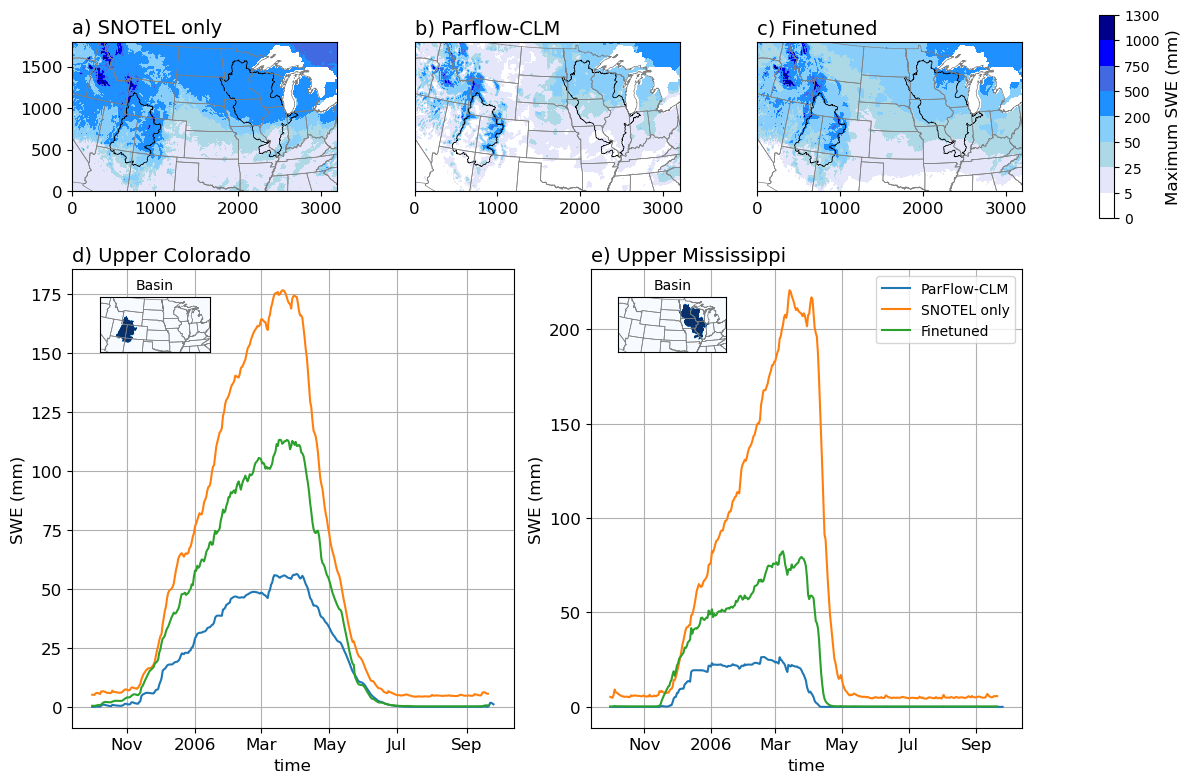

In [18]:

fontsize_fig=12

# Define the colors and corresponding ranges
colors = ['white', 'lavender', 'lightblue', 'lightskyblue', 'dodgerblue', 'royalblue', 'blue', 'darkblue']
ranges = [0, 5, 25, 50, 200, 500, 750, 1000, 1300]  # Define 8 intervals

# Create the colormap using ListedColormap
cmap = ListedColormap(colors)

# Create BoundaryNorm to map values to the colormap based on the defined ranges
norm = BoundaryNorm(boundaries=ranges, ncolors=len(colors))

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 7, figure=fig, width_ratios=[1, 0.9, 1, 0.9, 1, 0.9, 0.15])  # Reduce space between subplots



vmax = 1300
bins = 500

# First subplot
ax1 = fig.add_subplot(gs[0, 0:2]) 
img1 = ax1.imshow(obs_test.swe.max(dim='time'), origin='lower', cmap=cmap, norm=norm)
ax1.set_title('a) SNOTEL only', loc='left', fontsize=fontsize_fig+2)
plt.plot(x_coords_Colo, y_coords_Colo, color='black', lw=0.5)
plt.plot(x_coords_Missi, y_coords_Missi, color='black', lw=0.5)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

# Second subplot
ax2 = fig.add_subplot(gs[0, 2:4]) 
img2 = ax2.imshow((true_test.swe * mask).max(dim='time'), origin='lower', cmap=cmap, norm=norm)
ax2.set_title('b) Parflow-CLM', loc='left', fontsize=fontsize_fig+2)
ax2.set_yticks([])
plt.plot(x_coords_Colo, y_coords_Colo, color='black', lw=0.5)
plt.plot(x_coords_Missi, y_coords_Missi, color='black', lw=0.5)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

# Third subplot
ax3 = fig.add_subplot(gs[0, 4:6]) 
img3 = ax3.imshow(fine_test.swe.max(dim='time'), origin='lower', cmap=cmap, norm=norm)
ax3.set_title('c) Finetuned', loc='left', fontsize=fontsize_fig+2)
ax3.set_yticks([])
plt.plot(x_coords_Colo, y_coords_Colo, color='black', lw=0.5)
plt.plot(x_coords_Missi, y_coords_Missi, color='black', lw=0.5)
plt.xticks(fontsize=fontsize_fig)
plt.yticks(fontsize=fontsize_fig)

gdf.geometry.boundary.plot(ax=ax1, color='grey', lw=0.5)
gdf.geometry.boundary.plot(ax=ax2, color='grey', lw=0.5)
gdf.geometry.boundary.plot(ax=ax3, color='grey', lw=0.5)

ax1.set_xlim(0,3200)
ax1.set_ylim(0,1800)
ax2.set_xlim(0,3200)
ax2.set_ylim(0,1800)
ax3.set_xlim(0,3200)
ax3.set_ylim(0,1800)


# Add a single colorbar for all subplots
cbar_ax = fig.add_subplot(gs[0, 6])  # Extra axis for colorbar
cbar = fig.colorbar(img1, cax=cbar_ax, boundaries=ranges)
cbar.ax.set_ylabel('Maximum SWE (mm)',fontsize=fontsize_fig)  # Add label to colorbar



HUC2_names = {
    "1" : "New England",
    "2" : "Mid-Atlantic",
    "3" : "South Atlantic-Gulf",
    "4" : "Great Lakes",
    "5" : "Ohio",
    "6" : "Tennessee",
    "7" : "Upper Mississippi",
    "8" : "Lower Mississippi",
    "9" : "Souris-Red-Rainy",
    "10" : "Missouri",
    "11" : "Arkansas-White-Red",
    "12" : "Texas-Gulf",
    "13" : "Rio Grande",
    "14" : "Upper Colorado",
    "15" : "Lower Colorado",
    "16" : "Great Basin",
    "17" : "Pacific Northwest",
    "18" : "California" 
}




HUC2 = rioxarray.open_rasterio(parent_dir + '/Analysis/shp/HUC2_CONUS1_grid.tif')
ii=1

letters = ['d) ', 'e) ']
for i in [14,7]:
    mask = HUC2.isel(y=slice(None, None, -1))
    mask = mask.isel(x=slice(0,3200), y=slice(0,1800)) == i
    mask = xr.concat([mask] * 360, dim='time').squeeze('band')
    mask = mask.where(mask, 0)
    if mask.sum() != 0:
        mask['time'] = true_test.swe.time
        mask = mask.drop_vars('band')
        mask['x'] = true_test.swe.x
        mask['y'] = true_test.swe.y

        clipped_parflow = true_test.swe * mask
        clipped_y_hat = obs_test.swe * mask
        clipped_y_hat2 = fine_test.swe * mask

        scale_factor = (1/mask.isel(time=0).sum()).values

        ax4 = fig.add_subplot(gs[1:3, 3*(ii - 1): 3*ii]) 
        (clipped_parflow.sum(dim={'x','y'}) * scale_factor).plot(label='ParFlow-CLM', ax=ax4)
        (clipped_y_hat.sum(dim={'x','y'}) * scale_factor).plot(label='SNOTEL only', ax=ax4)
        (clipped_y_hat2.sum(dim={'x','y'}) * scale_factor).plot(label='Finetuned', ax=ax4)

        ax4.set_title("")
        max_swe = (clipped_parflow.sum(dim={'x','y'}) * scale_factor).values.max()
        if ii != 1:
            plt.legend()
        ax4.set_xlabel('time',fontsize=fontsize_fig)
        ax4.set_ylabel('SWE (mm)',fontsize=fontsize_fig)
        ax4.set_title(letters[ii-1] + HUC2_names[str(i)],loc='left', fontsize=fontsize_fig+2)
        plt.xticks(fontsize=fontsize_fig)
        plt.yticks(fontsize=fontsize_fig)

        ax4.grid()

        # Create inset axes
        inset_ax = inset_axes(ax4, width="25%", height="12%", loc='upper left', borderpad=2)

        # Add an image to the inset plot
        inset_image = inset_ax.imshow(mask.isel(time=0), cmap='Blues',origin='lower')
        
        gdf.geometry.boundary.plot(ax=inset_ax, color='gray', lw=0.5)

        # Set limits for the inset axis
        inset_ax.set_xlim(0, 3200)
        inset_ax.set_ylim(0, 1800)  # Bottom remains as origin

        # Optional: Adjust aspect ratio if needed
        inset_ax.set_aspect('auto')  # or 'equal', depending on your needs

        # Optional: Remove ticks and labels from inset
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        
        inset_ax.set_title('Basin', fontsize=fontsize_fig-2)
        
        ii = ii + 1



plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig('Fig5.jpg', bbox_inches='tight', pad_inches=0.1)